# Delay embeddings for simple pendulum

In [29]:
import numpy as np
from numpy import random
from importlib import reload
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


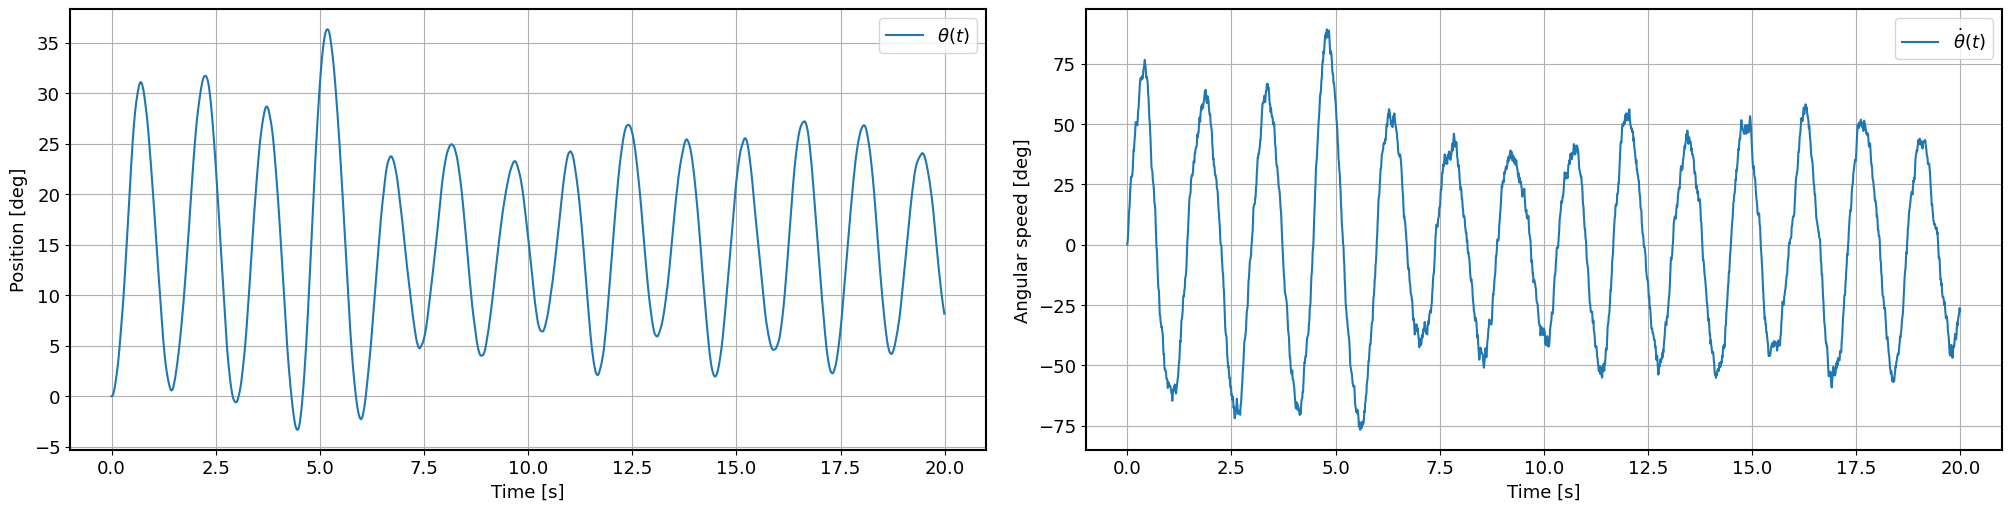

In [79]:
pend1 = SimplePendulum(mass=1, length=1) # Create pendulum instance
pend1.T, pend1.X0 = np.arange(0,20,pend1.dt), np.array([deg2rad(0),0])
pend1.U = 5*np.random.rand(len(pend1.T))
pend1.X = RK4(pend1.dynamics, pend1.X0, pend1.U, pend1.T)

# Plots
fig, ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(pend1.T, rad2deg(pend1.X[0,:]), label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(pend1.T, rad2deg(pend1.X[1,:]), label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

## Delay embeddings
The base regression problem writes under the form : <br><br>
$$\begin{pmatrix} x_1(k+1) \\ x_2(k+1) \end{pmatrix} = \begin{pmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{pmatrix} \begin{pmatrix} x_1(k) \\ x_2(k) \end{pmatrix} + \begin{pmatrix} B_{1} \\ B_{2} \end{pmatrix} u(k) \Longrightarrow \begin{pmatrix} x_1(1) & x_2(1) \\ \vdots & \vdots \\ x_1(T) & x_2(T) \end{pmatrix} = \begin{pmatrix} x_1(0) & x_2(0) & u(0) \\ \vdots & \vdots & \vdots \\ x_1(T-1) & x_2(T-1) & u(T-1) \end{pmatrix} \begin{pmatrix} A_{11} & A_{21} \\ A_{12} & A_{22} \\ B_1 & B_2 \end{pmatrix} $$ <br><br>

However, this assumes that every single observation only linearly depends on the preceding one. This assumptions can be removed by setting a delay $\tau$ and now assuming that each state can be linearly expressed as a combination of the $\tau$ preceding states. In a Koopman framework, this can be thought as a state extension since the matrices $A$ and $B$ will both be extended too. Considering only one measurement at a time, this yields : <br><br>

$$ \begin{pmatrix} x_1(k+1) \\ x_2(k+1) \end{pmatrix} = \begin{pmatrix} A_{11} & A_{12} & A_{13} & \cdots & A_{(1,\tau/2-2)} & A_{(1,\tau/2-1)} \\ A_{21} & A_{22} & A_{23} & \cdots & A_{(2,\tau/2-1)} & A_{(2,\tau/2-1)} \end{pmatrix} \begin{pmatrix} x_1(k) \\ x_2(k) \\ x_1(k-1) \\ x_2(k-1) \\ \vdots \\ x_1(k-\tau) \\ x_2(k-\tau) \end{pmatrix} + \begin{pmatrix} B_{1} \\ B_{2} \end{pmatrix} u(k) $$<br><br>

This assumption was however not proposed for the input, for now (let's consider things separately at first). Of course, all of this will be set up by taking the whole simulation horizon into account for a more accurate result.<br><br>

$$ \begin{pmatrix} x_1(k+1) & x_2(k+1) \\ \vdots & \vdots \\ x_1(k+T) & x_2(k+T) \end{pmatrix} = \begin{pmatrix} x_1(k) & x_2(k) & x_1(k-1) & x_2(k-1) & \cdots & x_1(k-\tau) & x_2(k-\tau) & u(k) & \cdots & u(k-\tau) \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots \\ x_1(k+T-1) & x_2(k+T-1) & x_1(k+T-2) & x_2(k+T-2) & \cdots & x_1(k+T-1-\tau) & x_2(k+T-1-\tau) & u(T-1) & \cdots & u(T-1-\tau) \end{pmatrix} \begin{pmatrix} A_{11} & A_{21} \\ A_{12} & A_{22} \\ B_1 & B_2 \end{pmatrix} $$

In [95]:
horizon = np.int(len(pend1.T)/2) # Trajectory planning horizon
tau = 1 # Maximum delay allowed

DLS1 = DelayedLeastSquare(pend1.X, tau, horizon, pend1.U[:], nb_u=1)
DLS1.solve()
print(DLS1.A,DLS1.B)

[[-0.19036  0.99907]
 [ 0.99905  0.01   ]] [1.98485e-02 9.92576e-05]


In [67]:
# Simulations
x_hat = discreteSimulation(DLS1.A, DLS1.B, pend1.X0, pend1.U, pend1.T)